<a href="https://colab.research.google.com/github/romanielrai/AI/blob/main/regression2517208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core libraries
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing & ML
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression


# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load dataset (DO NOT use sklearn datasets)
df = pd.read_csv('/content/drive/MyDrive/household_energy_consumption.csv')


# Display structure
print(df.head())
print(df.info())
print(df.describe())

  Household_ID        Date  Energy_Consumption_kWh  Household_Size  \
0       H00001  2025-04-01                     8.4               4   
1       H00001  2025-04-02                     7.9               4   
2       H00001  2025-04-03                     9.2               4   
3       H00001  2025-04-04                     7.9               4   
4       H00001  2025-04-05                     9.6               4   

   Avg_Temperature_C Has_AC  Peak_Hours_Usage_kWh  
0               17.8     No                   3.2  
1               17.3     No                   2.8  
2               18.6     No                   3.0  
3               18.2     No                   2.7  
4               11.9     No                   3.2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Household_ID            90000 non-null  object 


In [ ]:
# Missing values
print(df.isnull().sum())


# Duplicates
print("Duplicate rows:", df.duplicated().sum())


# Basic outlier check using IQR
numeric_df = df.select_dtypes(include=np.number)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()
print("Outliers per feature:\n", outliers)

Household_ID              0
Date                      0
Energy_Consumption_kWh    0
Household_Size            0
Avg_Temperature_C         0
Has_AC                    0
Peak_Hours_Usage_kWh      0
dtype: int64
Duplicate rows: 0
Outliers per feature:
 Energy_Consumption_kWh      0
Household_Size              0
Avg_Temperature_C         595
Peak_Hours_Usage_kWh        0
dtype: int64


In [ ]:
# Drop duplicates
df = df.drop_duplicates()


# Fill missing values with median
df = df.fillna(df.median(numeric_only=True))


# Encode categorical features
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
scaler = StandardScaler()
X = df.drop(columns=['Energy_Consumption_kWh'])
y = df['Energy_Consumption_kWh']
X_scaled = scaler.fit_transform(X)

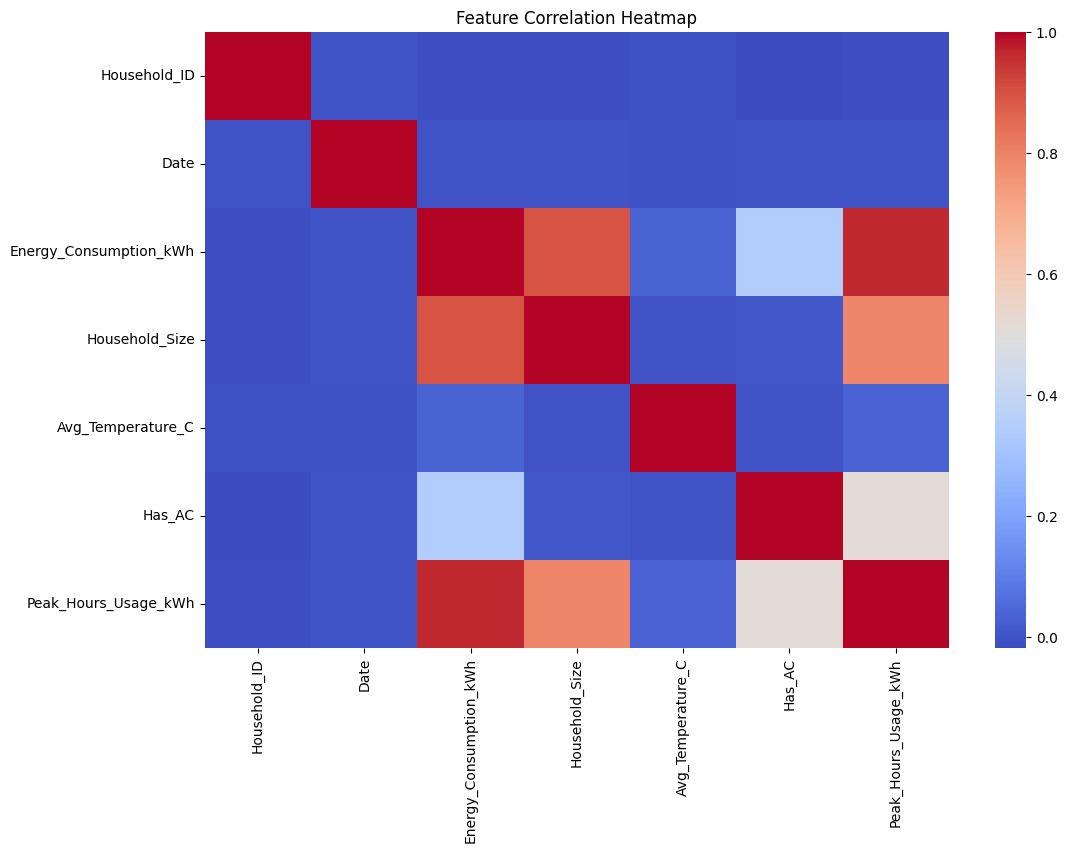

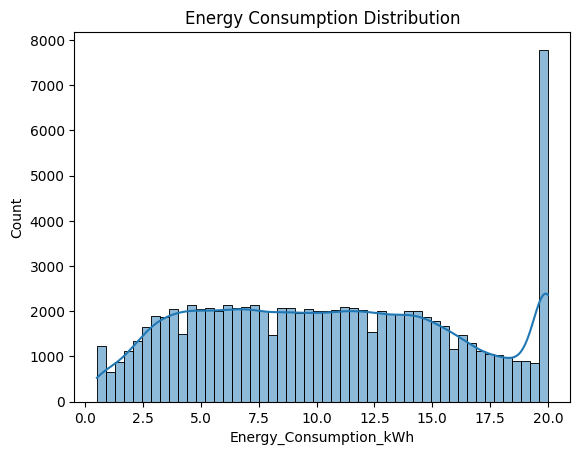

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


# Target distribution
sns.histplot(y, kde=True)
plt.title("Energy Consumption Distribution")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
Dense(32, activation='relu'),
Dense(1) # Regression output
])


model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])


history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
y_pred_train_nn = model.predict(X_train).flatten()
y_pred_test_nn = model.predict(X_test).flatten()


def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2


nn_train_metrics = regression_metrics(y_train, y_pred_train_nn)
nn_test_metrics = regression_metrics(y_test, y_pred_test_nn)
print("NN Train:", nn_train_metrics)
print("NN Test:", nn_test_metrics)

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 826us/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
NN Train: (0.48733045905836764, 0.4114104546507595, np.float64(0.64141285818945), 0.9864965021843831)
NN Test: (0.4864965663890044, 0.41119245225817497, np.float64(0.641242896458257), 0.986497971926695)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
lr_metrics = regression_metrics(y_test, y_pred_lr)
rf_metrics = regression_metrics(y_test, y_pred_rf)
print("Linear Regression:", lr_metrics)
print("Random Forest:", rf_metrics)

Linear Regression: (0.6271197419164607, 0.6230341303860792, np.float64(0.7893251107028582), 0.9795418805162838)
Random Forest: (0.5036094444444446, 0.4608077402222222, np.float64(0.6788282111272499), 0.9848687907311825)


In [ ]:
# Using RandomForest for tuning
rf_params = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 5, 10, 20]
}


rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2')
rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)

Best RF Params: {'max_depth': 10, 'n_estimators': 200}


In [ ]:
dt_params = {
'max_depth': [None, 5, 10, 20],
'min_samples_split': [2, 5, 10]
}


dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='r2')
dt_grid.fit(X_train, y_train)
print("Best DT Params:", dt_grid.best_params_)

Best DT Params: {'max_depth': 10, 'min_samples_split': 10}


In [ ]:
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['Household_ID', 'Household_Size', 'Avg_Temperature_C', 'Has_AC',
       'Peak_Hours_Usage_kWh'],
      dtype='object')


In [ ]:
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_selected, y, test_size=0.2, random_state=42)


# Train final models
rf_final = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
rf_final.fit(X_train_fs, y_train_fs)


lr_final = LinearRegression()
lr_final.fit(X_train_fs, y_train_fs)


# Predictions
rf_final_pred = rf_final.predict(X_test_fs)
lr_final_pred = lr_final.predict(X_test_fs)

In [ ]:
results = pd.DataFrame({
'Model': ['Neural Network', 'Linear Regression', 'Random Forest'],
'MAE': [nn_test_metrics[0], lr_metrics[0], rf_metrics[0]],
'RMSE': [nn_test_metrics[2], lr_metrics[2], rf_metrics[2]],
'R2': [nn_test_metrics[3], lr_metrics[3], rf_metrics[3]]
})
print(results)

               Model       MAE      RMSE        R2
0     Neural Network  0.486497  0.641243  0.986498
1  Linear Regression  0.627120  0.789325  0.979542
2      Random Forest  0.503609  0.678828  0.984869
